# LMUNet: Landscape metrics unet

**ORIGINAL SOURCE:** [Top 100 solution - SIIM-ACR Pneumothorax Segmentation](https://amaarora.github.io/2020/09/06/siimacr.html#train-and-valid-augmentations)

The Data-structure should look like this (old names: 

```
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
└── src
    └── pneumothorax-segmentation 
```


## Preparations

### a)  Imports

remove obsolete ones

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
#from torch.nn import MSELoss
from torcheval.metrics import MeanSquaredError, R2Score
from collections import defaultdict
import torchvision
#import albumentations as albu
#from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

# dataset and unet (could also add to this file, hmm!
from Dataset_test_many_metrics import LandscapeMetricsDataset
from unet_num_metr import unet, Decoder

#from torch.utils.data.sampler import Sampler
#import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
#from Losses import ComboLoss, dice_metric
#os.cpu_count()

block_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 128, 64, 64])
encoder_test torch.Size([1, 256, 32, 32])
encoder_test torch.Size([1, 512, 16, 16])
decoder_test torch.Size([1, 64, 64, 64])
unet_output_dim_test torch.Size([1, 1, 128, 128])


In [2]:
#import tqdm
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

### b) Config (Hyperparameters)

In [3]:
DATA_DIR         = Path(f'../notebooks/data')
TRAIN_IMG_DIR    = DATA_DIR/'100k_landscapes_5_class' # 5 class 100k
TRAIN_DF         = pd.read_csv('data/100k_joinent_5_class_metric_list.csv', header=None) #100k 5 class

In [4]:
# USE THIS IF TRAINING SINGLE CHANNEL METRIC
METRIC_NAME = 'ndca'
#METRIC_NAME = None

if METRIC_NAME:
    metr_norm = [(0, 'lsm_l_' + METRIC_NAME)]
    TRAIN_METRIC     = f'100k_{METRIC_NAME}_5_class_metr'

In [5]:
# USE THIS IF TRAINING MULTI-CHANNEL-METRICS

if not METRIC_NAME:
    METRIC_NAME = 'multi_metrics_7'
    TRAIN_METRIC     = f'100k_5cl_{METRIC_NAME}'
    METRIC_NAMES = pd.read_csv(f'data/{METRIC_NAME}.csv', header=None)[0]   

    #METRIC_NAMES         = pd.read_csv(f'data/all_metrics_ordered_short.csv', header=None)
    #METRIC_NAMES         = pd.read_csv(f'data/all_metrics_ordered.csv', header=None)    
    #METRIC_NAMES = ['lsm_l_dcad'] *50
    
    metr_norm = []
    for idx, metr_name in enumerate(METRIC_NAMES):
        metr_norm.append((idx, metr_name))
        #print(metr_norm)
print(metr_norm)

[(0, 'lsm_l_ndca')]


In [6]:
TRAIN_LBL_DIR    = DATA_DIR/TRAIN_METRIC # 100k 5 class
OUTPUT_DIR       = Path(f'outputs/saved_models/{TRAIN_METRIC}')
TRAIN_LOG        = OUTPUT_DIR/'output_log.txt'

print(TRAIN_LBL_DIR)
print(OUTPUT_DIR)

../notebooks/data/100k_ndca_5_class_metr
outputs/saved_models/100k_ndca_5_class_metr


In [7]:
TRAIN_MODEL      = True
EVALUATE         = True
PRETRAINED       = False

TEST_MODEL       = False

GRID_SEARCH      = False
GRID_SEARCH_OPTIM= False

In [8]:
if TEST_MODEL or PRETRAINED:
    #PRETRAINED_DIR   = Path(f'../notebooks/outputs/saved_models')
    #PRETRAINED_PATH  = 'PRETRAINED_DIR/100k_frac_mn_5_class_metr/bst_model128_fold8_0.9017.bin'
    PRETRAINED_PATH  = 'outputs/saved_models/100k_5cl_joinent_frac_mn_area_cv_dcad_pladj_sidi/bst_model_100k_5cl_joinent_frac_mn_area_cv_dcad_pladj_sidi_bs:16_nw:0_nm:6_lf:HL_NAN_ep:49_0.7556_lr:2e-05.bin'

In [9]:
IMG_SIZE         = 128
DATASET_LENGHTS  = [80000,15000,5000] # example split for 100k
BATCH_SIZE       = 16
TEST_BATCH_SIZE  = BATCH_SIZE
TRAIN_BATCH_SIZE = BATCH_SIZE
VALID_BATCH_SIZE = BATCH_SIZE
DEVICE           = 'cuda'
LEARNING_RATE    = 2e-5
EPOCHS           = 100
LOSS_FN          = 'HL_NAN' #'HL' # HuberLoss ['MSE','RMSE','MAE'
EVAL_FN          = 'R2' # ['MSE']
USE_CRIT         = True
NUM_WORKERS      = 0 # was 12, but much stronger with 0; also try 4 (GS?)
#NUM_METRICS      = 1 # automaticalyl detect channel amount later on

### c) Visualization functions

In [10]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(img.permute(1,2,0).numpy())

In [11]:
def visualize(landscape, metric, left_title = "Landscape", right_title = "Metric", suptitle = None):
    """PLot images in one row."""
    columns = 2
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(suptitle)
    fig.add_subplot(rows, columns, 1)
    plt.title(left_title)
    #landscape, metric = landscapes['landscape'], landscapes['metric']
    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)
    plt.imshow(landscape)
    plt.colorbar(fraction=0.046, pad=0.04)
    fig.add_subplot(rows, columns, 2)
    plt.title(right_title)
    #plt.suptitle(right_st)
    #plt.title("Metric")
    plt.imshow(metric)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

## Dataset

### f) Dataset

In [12]:
full_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, metr_norm=metr_norm)
#full_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, metr_norm=None)

In [13]:
#if loading multiple datasets from multiple folders with different indices:
# ie 3 classes + 5 classes
'''
train_dataset_01 = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
train_dataset_02 = LandscapeMetricsDataset(TRAIN_DF_02, TRAIN_IMG_DIR_02, TRAIN_LBL_DIR_02)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
len(train_dataset_02)
train_dataset_02[1]
'''

'\ntrain_dataset_01 = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TFMS)# , TFMS)#, augmentation=transforms_train) \ntrain_dataset_02 = LandscapeMetricsDataset(TRAIN_DF_02, TRAIN_IMG_DIR_02, TRAIN_LBL_DIR_02)#, TFMS)# , TFMS)#, augmentation=transforms_train) \nlen(train_dataset_02)\ntrain_dataset_02[1]\n'

In [14]:
#concatenate both
#train_dataset = torch.utils.data.ConcatDataset([train_dataset_01, train_dataset_02])

In [15]:
len(full_dataset)

100000

In [16]:
# random_split conventinoally a 10k dataset
#from torch.utils.data import random_split

train_dataset, val_dataset, test_dataset = random_split(dataset=full_dataset, 
                                                        lengths=DATASET_LENGHTS,
                                                        generator=torch.Generator().manual_seed(42))

In [17]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

80000 15000 5000


In [18]:
# sanity check
landscape, metric = train_dataset[136]['landscape'], train_dataset[136]['metric']
#landscape = train_dataset[1]['landscape']

landscape.shape, metric.shape
# (torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

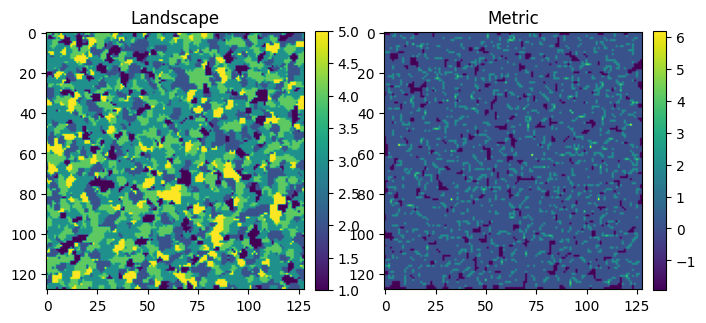

In [19]:
# plot one with mask 
visualize(train_dataset[1]['landscape'].squeeze(), train_dataset[0]['metric'][0].squeeze())

### h) DataLoaders

In [20]:
# dataloaders
# shuffle = True means random sampler, which is fine.
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True, num_workers=NUM_WORKERS)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, 
                              shuffle=False, num_workers=NUM_WORKERS)

In [21]:
# sanity check
landscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']
landscapes.shape, metrics.shape
# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))

(torch.Size([16, 1, 128, 128]), torch.Size([16, 1, 128, 128]))

In [22]:
# plot train images
#ls_grid = torchvision.utils.make_grid(landscapes[:9], nrow=3, normalize=True)
#matplotlib_imshow(ls_grid)

In [23]:
#metr_grid = torchvision.utils.make_grid(metrics[:9], nrow=3, normalize=True)
#matplotlib_imshow(metr_grid)

## Model and Training

### i) Loss

In [24]:
if LOSS_FN == 'MAE':
    criterion = nn.L1Loss()

elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
    criterion = nn.MSELoss()  

elif LOSS_FN == 'HL':
    criterion = nn.HuberLoss()

In [25]:
# custom huber loss for ignoring NaN
if LOSS_FN == 'HL_NAN':

#import torch
#import torch.nn as nn

    class HuberLossNan(nn.HuberLoss):
        def __init__(self, reduction='mean', delta=1.0):
            super(HuberLossNan, self).__init__(reduction=reduction)
            self.delta = delta

        def forward(self, input, target):
            #nan_mask = torch.isnan(input) | torch.isnan(target)
            #nan_mask = torch.isnan(target) | torch.isnan(target) # only remove of target, as that's the relevant ones!
            nan_mask = torch.isnan(target)
            valid_mask = ~nan_mask

            input_valid = input[valid_mask]
            target_valid = target[valid_mask]

            loss = super(HuberLossNan, self).forward(input_valid, target_valid)
            return loss

    criterion = HuberLossNan()

In [26]:
criterion

HuberLossNan()

### j) Model

From [PyTorch Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch):

In [27]:
NUM_METRICS = metrics.shape[1] # 
model = unet(num_metr=NUM_METRICS)
#model = model.half()

### k) Early Stopping

epoch_score = accuracy at that epoch
model_path = where to save the model
patience = after how many steps of no progress to stop training

Saves one model when beginning, i.e. when no best score is yet available.
Why np.copy ? Maybe to turn epoch_score it into np object?

IF the accuracy (+delta) decreased: patience counter incremented by one, stopping once patience is reached.
Otherwise: continue trianing, reset counter, update best score with new score.

Save checkpoint: sved best score is intermittently saved as val_score, new best_score is compared to old val_score and printed out, state_dict is saved at model path.

In [28]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001): # how big delta?
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)

        elif ((EVAL_FN == 'MSE' and score > self.best_score - self.delta) or 
              (EVAL_FN == 'R2' and score < self.best_score + self.delta)):

            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
            
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

### l) Averagemeter

Averagemeter plays a role in taking care of the losses.

It's initialized in train_one_epoch, having the values set at zero.
Reset appears to be unused.
It gets updated with the current loss, which is handed as "val", and batch_size as n.
val is therefore the loss score.
sum is previous sum loss score plus val multiplied by batch size.
count is previous batches + new one
avg is sum of all loss scores divided by count of all batches.

Train one epoch is doing what it says it does.

In [29]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### m) Train one epoch

In [30]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
            #print(data['landscape'].size())
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['landscape'])
        #print(out.size())
        loss = loss_fn(out, data['metric'])
        if LOSS_FN == 'RMSE':
            loss = torch.sqrt(loss)
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [31]:
#print(train_one_epoch(train_loader=train_dataloader, model=model, optimizer=optimizer, loss_fn=criterion, accumulation_steps=1, device='cuda'))

### n) Evaluation Metric

In [32]:
# from ChatGPT adjusted:
# "When using Mean Squared Error (MSE) loss for image regression in PyTorch,
# you can compute the validation accuracy function using the following code:"
# useing torcheval.metrics.MeanSquaredError()
# torcheval.metrics.R2Score

#https://pytorch.org/torcheval/main/torcheval.metrics.html#regression-metrics
from torcheval.metrics import MeanSquaredError, R2Score

# set mode 'min' when using MSE for validation in evalution functions?

if EVAL_FN == 'MSE':
    eval_metric = MeanSquaredError()
    
elif EVAL_FN == 'R2':
    eval_metric = R2Score()

def evaluate(val_loader, model, device='cuda', criterion=eval_metric):
    """
    Computes the validation accuracy of the model on the validation set.
    """
   
    model = model.to(device)
    model.eval() # set the model to evaluation mode
    tk0 = tqdm(val_loader, total=len(val_loader))

    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['landscape'])  
                     
            # chatgpt suggest flaten:
            targets = data['metric']
            
            # dealing with NaNs:
            nan_mask = torch.isnan(targets)
            valid_mask = ~nan_mask
            targets = targets[valid_mask]
            out = out[valid_mask]
            
            targets_flat = targets.view(targets.shape[0], -1).cpu()
            outputs_flat = out.view(out.shape[0], -1).cpu()
            criterion.update(outputs_flat, targets_flat)            
            val_loss = criterion.compute().item()            
            tk0.set_postfix(val_score=val_loss)
            
        criterion.reset()

    return val_loss#.item()

In [33]:
# testing evaluation function on pretrained model

#best_model_path = PRETRAINED_PATH
#model.load_state_dict(torch.load(best_model_path))
#model = model.to('cuda')
#print(evaluate(val_loader=val_dataloader, model=model, device='cuda', criterion=eval_metric))


In [34]:
# let's try this:
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

In [36]:
es = EarlyStopping(patience=10, mode='max')

In [37]:
criterion

HuberLossNan()

In [38]:
if TRAIN_MODEL:
    def save_best_hyperparam(text, path):
        """
        Function to save best hyperparameters in a `.csv` file.
        :param text: The hyperparameters dictionary.
        :param path: Path to save the hyperparmeters.
        """
        with open(path, 'a') as f:  
            if os.stat(path).st_size == 0:
                f.write(f"{str(text.keys())[11:-2]}\n")

            f.write(f"{str(text.values())[13:-2]}\n")

In [ ]:
#%%capture --no-stderr # try to automatically write ouptu to file at some point?
#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html

if TRAIN_MODEL:
    
    #directory to save the state dicts and log in:
    os.mkdir(OUTPUT_DIR)
    
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        eval_score = evaluate(val_dataloader, model, criterion=eval_metric)#.item() # eval_score is a tensor-->item
        scheduler.step()

        param_dict = {
            'METR NAME'   : TRAIN_METRIC,
            'EPOCH'       : epoch, 
            'TRAIN LOSS'  : np.round(loss, 4),
            'VAL SCORE'   : np.round(eval_score,4), 
            'LOSS FN'     : LOSS_FN, 
            'BATCH SZ'    : TRAIN_BATCH_SIZE,
            'NUM WORKERS' : NUM_WORKERS,
            'NUM METRICS' : NUM_METRICS,   
            'LEARN RATE'  : np.round(optimizer.param_groups[0]['lr'], 4), # print_lr(is_verbose, group, lr, epoch=None) Display the current learning rate.
        }
        
        #param_string = str(param_dict)        
        param_string = f"{TRAIN_METRIC}_bs:{TRAIN_BATCH_SIZE}_nw:{NUM_WORKERS}_nm:{NUM_METRICS}_lf:{LOSS_FN}_ep:{str(epoch).rjust(2, '0')}_{np.round(eval_score,4)}_lr:{np.round(optimizer.param_groups[0]['lr'], 4)}"        # dubbel, maybe adjust somehow?
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}")
        #es(eval_score, model, model_path=f"{OUTPUT_DIR}/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
        es(eval_score, model, model_path=f"{OUTPUT_DIR}/bst_model_{param_string}.bin")
        save_best_hyperparam(param_dict, f"{OUTPUT_DIR}/best_param.csv")
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
        
            
# evaluate on test data right away after trainig 
if EVALUATE: 
    test_dataloader = DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    #valid_score = evaluate(val_dataloader, model, metric=metric)
    test_score = evaluate(test_dataloader, model, criterion=eval_metric)    

 25%|██▌       | 1256/5000 [03:55<11:47,  5.29it/s, learning_rate=2e-5, loss=0.327]

In [ ]:
if EVALUATE: 
    print(f"Test evaluation R2 score: {test_score}")

## Testing

### p) Predict Test Landscapes (single-model)

In [ ]:
#TEST_MODEL = True

In [ ]:
if TEST_MODEL or GRID_SEARCH or GRID_SEARCH_OPTIM:
    #test_dataset   = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TEST_TFMS) 
    test_dataloader = DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# could acces OUTPUT_DIR and latest_file from that dir here to automatically open the desired dict
if TEST_MODEL and not TRAIN_MODEL:
    best_model_path = PRETRAINED_PATH    
    model.load_state_dict(torch.load(best_model_path))

In [ ]:
if TEST_MODEL and not TRAIN_MODEL:
    model = model.to('cuda')

In [ ]:
# test data evaluation score
if TEST_MODEL:
    test_score = evaluate(test_dataloader, model, criterion=eval_metric)

In [ ]:
#combine test prediction and eval function?? gmmm, maybe not...

if TEST_MODEL:
    def predict(test_dataloader, model, device='cuda'):
        predicted_pixels = []
        losses = AverageMeter()
        model = model.to(device)
        model.eval()
        tk0 = tqdm(test_dataloader, total=len(test_dataloader))
        for b_idx, data in enumerate(tk0):
            data['landscape'] = data['landscape'].to(device)
            out   = model(data['landscape'])
            out   = out.detach().cpu().numpy()#[:, 0, :, :] 
            for out_ in out:
                 predicted_pixels.append(out_)
        return predicted_pixels
    

In [ ]:
if TEST_MODEL:
    predicted_metric = predict(test_dataloader,model)

In [ ]:
if TEST_MODEL:
    visualize(test_dataset[3]['landscape'].squeeze(), test_dataset[3]['metric'][0].squeeze())

In [ ]:
if TEST_MODEL:
    print(type(predicted_metric))
    print(len(predicted_metric))

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][0].squeeze(), predicted_metric[3][0].squeeze(), 
              left_title=f"Target Metric {METRIC_NAMES[0]}", 
              right_title=f"Prediction Metric {test_score}")

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][1].squeeze(),predicted_metric[3][1].squeeze(), 
              left_title= f"Target Metric {METRIC_NAMES[1]}", right_title = f"Prediction Metric {METRIC_NAMES[1]}")

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][2].squeeze(),predicted_metric[3][2].squeeze(), 
              left_title= f"Target Metric {METRIC_NAMES[2]}", right_title = f"Prediction Metric {METRIC_NAMES[2]}")

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][3].squeeze(),predicted_metric[3][3].squeeze(), 
              left_title= f"Target Metric {METRIC_NAMES[3]}", right_title = f"Prediction Metric {METRIC_NAMES[3]}")

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][4].squeeze(),predicted_metric[3][4].squeeze(), 
              left_title= f"Target Metric {METRIC_NAMES[4]}", right_title = f"Prediction Metric {METRIC_NAMES[4]}")

In [ ]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[3]['metric'][5].squeeze(),predicted_metric[3][5].squeeze(), 
              left_title= f"Target Metric {METRIC_NAMES[5]}", right_title = f"Prediction Metric {METRIC_NAMES[5]}")

In [ ]:
#if TEST_MODEL:
#    print(set(test_dataset[4]['metric'].squeeze()[1]))

In [ ]:
#if TEST_MODEL:
#    print(set(predicted_metric[4].squeeze()[1]))

In [ ]:
#if TEST_MODEL:
    #difference_loss = test_dataset[3]['metric']-predicted_metric[3]
    #difference_loss = abs(test_dataset[5]['metric']-predicted_metric[5])
    #(test_dataset[5]['metric']-predicted_metric[5]).squeeze()
    
    #visualize(test_dataset[3]['metric'].squeeze(),difference_loss.squeeze(), left_title= "Metric", right_title = "Residuals")
    #visualize(test_dataset[4]['metric'].squeeze(),predicted_metric[4].squeeze(), left_title= "Metric", right_title = "Prediction")

In [ ]:
#if TEST_MODEL:
    #print(np.count_nonzero(difference_loss))
    #128*128 == 16384
    #print(set(difference_loss.squeeze()))

### Evaluating only single metrics

In [ ]:
TEST_MODEL_SINGLE = True

In [ ]:
# in case of multiple metrics for testing only one
#if TEST_MODEL_SINGLE:
#    predicted_metric_0 = np.expand_dims(np.array(predicted_metric)[:,0], axis=1)

In [ ]:
# from ChatGPT adjusted:
# "When using Mean Squared Error (MSE) loss for image regression in PyTorch,
# you can compute the validation accuracy function using the following code:"
# useing torcheval.metrics.MeanSquaredError()
# torcheval.metrics.R2Score

#https://pytorch.org/torcheval/main/torcheval.metrics.html#regression-metrics
#from torcheval.metrics import MeanSquaredError, R2Score

# reaplce norma levaulate function with this one?
if TEST_MODEL_SINGLE:

    if EVAL_FN == 'MSE':
        eval_metric = MeanSquaredError()

    elif EVAL_FN == 'R2':
        eval_metric = R2Score()

    def evaluate_test(val_loader, model, device='cuda', criterion=eval_metric, channel=None):
    #def evaluate_test(val_loader, model, device='cuda', criterion=eval_metric, channel=[0:-1]): #not working because string

        """
        Computes the validation accuracy of the model on the validation set.
        """
        #model = model.to(device)
        model.eval() # set the model to evaluation mode
        tk0 = tqdm(val_loader, total=len(val_loader))

        with torch.no_grad():
            for b_idx, data in enumerate(tk0):
                for key, value in data.items():
                    data[key] = value.to(device)

                out   = model(data['landscape'])  

                # chatgpt suggest flaten:
                targets = data['metric']     
                
                if channel or channel == 0: #if channel is a number or 0. weird syntax, maybe btter?
                    out = out[:, channel, :, :]
                    #print(out.shape)
                    targets = targets[:, channel, :, :]
                    #print(targets.shape)
                                        
                # dealing with NaNs:
                nan_mask = torch.isnan(targets)
                valid_mask = ~nan_mask
                targets = targets[valid_mask]
                out = out[valid_mask]

                targets_flat = targets.view(targets.shape[0], -1).cpu()
                outputs_flat = out.view(out.shape[0], -1).cpu()
                criterion.update(outputs_flat, targets_flat)#.cpu()            
                val_loss = criterion.compute().item()            
                tk0.set_postfix(val_score=val_loss)  

            criterion.reset()    

        return val_loss

In [ ]:
single_test_scores = []
for metric_channel in range(0, NUM_METRICS):
    test_score_single = evaluate_test(test_dataloader, model, criterion=eval_metric, channel=metric_channel)
    single_test_scores.append(test_score_single)
#print(single_test_scores)

In [ ]:
#if TEST_MODEL_SINGLE:
#    test_score_single = evaluate_test(test_dataloader, model, criterion=eval_metric, channel=0)

### q) Submit to Kaggle - `five fold`

In [ ]:
'''
def inference_image(model, images, device='cuda'):
    images = images.to(device)
    predicted = model(images)
    masks = torch.sigmoid(predicted)
    masks = masks.squeeze(1).cpu().detach().numpy()
    return masks
'''

In [ ]:
'''
def inference_model(model, loader, device, use_flip=False):
    mask_dict = {}
    for data in tqdm(loader):
        image_ids = data['image_id']
        images    = data['image']
        masks = inference_image(model, images, device)
        for name, mask in zip(image_ids, masks):
            mask_dict[name] = mask.astype(np.float32)
    return mask_dict
    '''

In [ ]:
'''
# Path to pretrained models from https://www.kaggle.com/aroraaman/siimacr-pretrained/
checkpoints_list=['../data/bst_model512_fold1_0.9492.bin', 
                  '../data/bst_model512_fold2_0.9565.bin', 
                  '../data/bst_model512_fold3_0.9608.bin', 
                  '../data/bst_model512_fold4_0.9604.bin']
'''

In [ ]:
'''
mask_dict = defaultdict(int)
for pred_idx, checkpoint_path in enumerate(checkpoints_list):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    current_mask_dict = inference_model(model, test_dataloader, device='cuda')
    for name, mask in current_mask_dict.items():
        mask_dict[name] = (mask_dict[name] * pred_idx + mask) / (pred_idx + 1)
        
'''

In [ ]:
#len(mask_dict)

def creat_search_run():
    """
    Function to save the Grid Search results.
    """
    num_search_dirs = len(glob.glob('../outputs/search_*'))
    search_dirs = f"../outputs/search_{num_search_dirs+1}"
    os.makedirs(search_dirs)
    return search_dirs
def save_best_hyperparam(text, path):
    """
    Function to save best hyperparameters in a `.yml` file.
    :param text: The hyperparameters dictionary.
    :param path: Path to save the hyperparmeters.
    """
    with open(path, 'a') as f:
        f.write(f"{str(text)}\n")Model Paths for ensemble
- `../data/bst_model512_0.8193.bin` (fold-0)
- `../data/bst_model512_fold1_0.9492.bin` (fold-1)
- `../data/bst_model512_fold2_0.9565.bin`(fold-2)
- `../data/bst_model512_fold3_0.9608.bin` (fold-3)

### r) Gridsearch

In [ ]:
if GRID_SEARCH or GRID_SEARCH_OPTIM:
    '''
    import glob as glob
    def creat_search_run():
        """
        Function to save the Grid Search results.
        """
        num_search_dirs = len(glob.glob(' ../notebooks/data/grid_search/search_*'))       
        search_dirs = f" ../notebooks/data/grid_search/search_{num_search_dirs+1}"
        os.makedirs(search_dirs)
        return search_dirs
    '''
    def save_best_hyperparam(text, path):
        """
        Function to save best hyperparameters in a `.yml` file.
        :param text: The hyperparameters dictionary.
        :param path: Path to save the hyperparmeters.
        """
        #if os.stat(path).st_size == 0:
         #   with open(path, 'a') as f:          
          #      f.write(f"{str(text.keys())[11:-2]}\n")

        with open(path, 'a') as f:  
            if os.stat(path).st_size == 0:
                f.write(f"{str(text.keys())[11:-2]}\n")

            #f.write(f"{str(text)}\n")
            f.write(f"{str(text.values())[13:-2]}\n")

In [ ]:
if GRID_SEARCH:
    from sklearn.model_selection import ParameterGrid

    # define the grid search parameters
    param_grid = {
        #val batch size doesn't really matter?       
        'TRAIN_BATCH_SIZE': [16],# 16],# 24]#, 32]#10, 20, 40, 60, 80, 100],  
        'LEARNING_RATE': [2e-5],# 2e-3, 0.01],#, 0.01]#,       
        'EPOCHS': [50],#, 50, 100],
        'LOSS_FN'   : ['HL'] #['MAE', 'MAE']#, 'RMSE', 'MAE']
        #'EVAL_FN' : ['R2']#['MSE', 
        #'NUM_WORKERS'      = [4, 8, 12]
    }
    
#list(ParameterGrid(param_grid))


In [ ]:
2e-5 * 1000

In [ ]:
if GRID_SEARCH:  
    
    es = EarlyStopping(patience=3, mode='max')
    
    for param_dict in ParameterGrid(param_grid):
        TRAIN_BATCH_SIZE = param_dict['TRAIN_BATCH_SIZE']
        LEARNING_RATE = param_dict['LEARNING_RATE']
        EPOCHS = param_dict['EPOCHS']
        LOSS_FN = param_dict['LOSS_FN']
        #EVAL_FN = param_dict['EVAL_FN']

            # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

        if LOSS_FN == 'MAE':
            criterion = nn.L1Loss()

        # MSE & RMSE
        elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
            criterion = nn.MSELoss()
        
        es.counter = 0

        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/outputs/grid_search/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            #save_best_hyperparam(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}, LOSS FN: {LOSS_FN}, BATCH SZ: {TRAIN_BATCH_SIZE}, LR: {LEARNING_RATE} ", f"../notebooks/data/grid_search/best_param.yml")
            #save_best_hyperparam(param_dict, f"../notebooks/data/grid_search/best_param.yml")
            save_best_hyperparam(param_dict, f"../notebooks/outputs/grid_search/best_param.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                #es.counter = 0
                break

In [ ]:
if GRID_SEARCH_OPTIM:  
    
    from torch import optim
    es = EarlyStopping(patience=3, mode='max')

    # define the grid search parameters
    optim_grid = [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                      optim.Adam, optim.Adamax, optim.NAdam]
    
    
    for o in optim_grid:
        print(o)
        optimizer = o(model.parameters(), lr= LEARNING_RATE)

        # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(test_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        #optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)
        
        es = EarlyStopping(patience=3, mode='max')

        #es.counter = 0
          
        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'OPTIMIZER': o, 'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/outputs/grid_search_optim/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            save_best_hyperparam(param_dict, f"../notebooks/outputs/grid_search_optim/best_optim.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                break